# Memory kernel and divisibility of Gaussian Collisional Models

### Created by Rolando Ramirez Camasca and Gabriel T. Landi

This notebook contains a full numerical suite for simulating the non-Markovian collisional models studied in the main text. There are 3 main sections:

### 1. General definitions and simulations ($\langle a^\dagger a\rangle$, mutual information etc.)

### 2. Memory Kernel

### 3. CP-divisibility

For each section, one must first run the cells entitled "Function definitions".
In each one there is also a "Quick sims" section, which provides a convenient platform for running simple tests.

Sec. 3 uses somewhat larger simulation data, which are provided in the .pkl files accompanying this notebook. This is simply for convenience. All data can be resimulated in approx. 2 hours (we point out in Sec. 3 the relevant codes for doing so). 

In [1]:
import sys
import numpy as np
import scipy as sp

from numpy import block
from scipy.linalg import block_diag, eigvals, kron
from numpy.linalg import matrix_power as mpow

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import ticker

#from tqdm import tqdm_notebook as tq   
# tq is an optional library, which requires external install. 
import pickle
import warnings
warnings.filterwarnings('ignore')

def tr(A):
    return np.sum(A.diagonal())

def save_obj(obj, name):
    with open(name + '.pkl','wb+') as f:
        pickle.dump(obj,f,pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f) 

# Returns (a), (b), (c), etc., to be used in the plot legends
letter = lambda i : '(' + chr(i+97) + ')'


# 1. General definitions and simulations

## Function definitions

In [2]:
# PLEASE RUN. NECESSARY FOR ALL SIMULATIONS

# Initial conditions
ϵ = np.array([[0.5,0],[0,0.5]])
θ0 = np.array([[20.5,0],[0,20.5]])
γ0= block_diag(θ0,ϵ)

# X, Y matrices of the Markovian embedding 
# BS
def XY_BS(λs, λe, ϵ):
    x = np.cos(λs)
    y = np.sin(λs)
    z = np.cos(λe)
    w = np.sin(λe)
    e00 = (z**2)*ϵ[0,0]
    e01 = (z**2)*ϵ[0,1]
    e10 = (z**2)*ϵ[1,0]
    e11 = (z**2)*ϵ[1,1]
    X = np.array([[x,0,y,0],[0,x,0,y],[y*w,0,-w*x,0],[0,y*w,0,-w*x]])
    Y = np.array([[0,0,0,0],[0,0,0,0],[0,0,e00,e01],[0,0,e10,e11]])
    return X, Y

#TMS
def XY_TMS(λs, νe, ϵ):
    x = np.cos(λs)
    y = np.sin(λs)
    z = np.cosh(νe)
    w = -np.sinh(νe)
    e00 = (z**2)*ϵ[0,0]
    e01 = (z**2)*ϵ[0,1]
    e10 = (z**2)*ϵ[1,0]
    e11 = (z**2)*ϵ[1,1]
    X = np.array([[x,0,y,0],[0,x,0,y],[-y*w,0,w*x,0],[0,+y*w,0,-w*x]])
    Y = np.array([[0,0,0,0],[0,0,0,0],[0,0,e00,e01],[0,0,e10,e11]])
    return X, Y

# Basic evolution loop
def step(X, Y, γ0, steps):
    
    if (type(γ0)==dict):
        n0 = np.max(list(γ0.keys()))
        γ = γ0.copy()        
    else:
        n0 = 0
        γ = dict()
        γ[0] = γ0

    for n in range(n0+1, n0+1+steps):
        γ[n] = X@γ[n-1]@X.T + Y
        
    return γ

# System occupation
ada = lambda γ : 0.5*(γ[0,0] + γ[1,1])

#Symplectic form
def Symplectic_Omega(X):
    ω = np.array([[0,1],[-1,0]])    
    if type(X) == int: 
        Ω = block_diag(*[ω for n in range(X)])
    else:
        N = int(len(X)/2)
        Ω = block_diag(*[ω for n in range(N)])
    return Ω

# Von Neumann entropy
def GaussianVonNeumann(σ):
    h = lambda x: 0 if(np.abs(x) < 10**(-16)) else x*np.log(x)
    g = lambda x: h((x+1)/2) - h((x-1)/2)
    N = int(len(σ)/2)
    Ω = Symplectic_Omega(σ)
    symp_eigs = eigvals(2.0*1j*Ω@σ)
    ent = 0
    for ν in np.sort(symp_eigs)[N:2*N]:
        ent = ent + g(ν)
    return np.real(ent)
    
# Mutual Information    
def MutualInformation(γ):
    θ = γ[0:2,0:2]
    ϵ = γ[2:4,2:4]
    S1 = GaussianVonNeumann(θ)
    S2 = GaussianVonNeumann(ϵ)
    S3 = GaussianVonNeumann(γ)
    return S1 + S2 - S3

# Quick sims

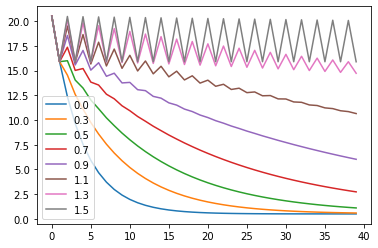

In [3]:
# <ada> for the BS
λs = 0.5
nf = 40
x = range(0,nf)
quick = dict()
for λe in [0.0, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]:
    X,Y = XY_BS(λs, λe, ϵ)
    quick[λe] = step(X, Y, γ0, nf)
    y = [ada(quick[λe][n]) for n in x]    
    plt.plot(x,y, label = λe)
plt.legend()
plt.show()        

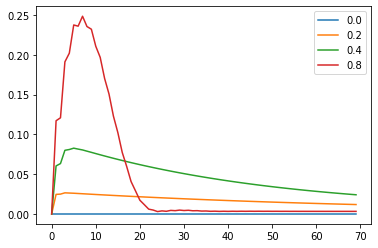

In [4]:
# Mutual information for the TMS dynamics
λs = 0.1
nf = 70
x = range(0,nf)
quick = dict()
for νe in [0.0,0.2,0.4,0.8]:
    X,Y = XY_TMS(λs, νe, ϵ)    
    quick[νe] = step(X, Y, γ0, nf)
    y = [MutualInformation(quick[νe][n]) for n in x]    
    plt.plot(x,y, label = νe)
plt.legend()
plt.show()    

## Panels for Sec. II: $\langle a^\dagger a\rangle$ and mutual information

In [5]:
# Simulations (very quick)
# BS
λs = 0.5
nf = 40
γBS = dict()
for λe in [-1.1, -0.9, -0.7, -0.5, -0.3, 0.0, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]:
    X,Y = XY_BS(λs, λe, ϵ)
    γBS[λe] = step(X, Y, γ0, nf)
    
# TMS    
λs = 0.1
nf = 160
γTMS = dict()
for νe in [0.0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.89, 0.9, 0.91, 0.92, 0.93]:
    X,Y = XY_TMS(λs, νe, ϵ)    
    γTMS[νe] = step(X, Y, γ0, nf)

### Panel for $\langle a^\dagger a \rangle$

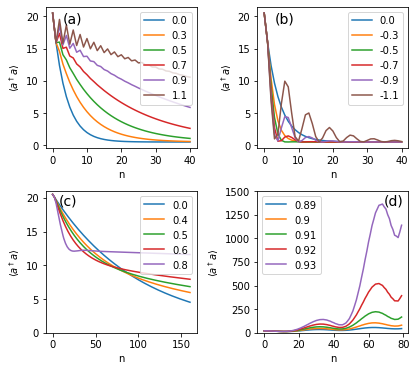

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (6.5,6))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

# (a) (BS)
for λe in [0.0, 0.3, 0.5, 0.7, 0.9, 1.1]:
    x = list(γBS[λe].keys())
    y = [ada(γBS[λe][n]) for n in x]
    ax1.plot(x, y, label = λe)
ax1.legend()    
ax1.set_xlabel('n')
ax1.set_ylabel(r'$\langle a^\dagger a \rangle$')
ax1.text(3,19,'(a)',fontsize=14)

# (b) (BS)
for λe in [0.0, -0.3, -0.5, -0.7,-0.9, -1.1]:
    x = list(γBS[λe].keys())
    y = [ada(γBS[λe][n]) for n in x]
    ax2.plot(x, y, label = λe)
ax2.legend()    
ax2.set_xlabel('n')
ax2.set_ylabel(r'$\langle a^\dagger a \rangle$')
ax2.text(3,19,'(b)',fontsize=14)

# (c) (TMS)
for νe in [0.0, 0.4, 0.5, 0.6, 0.8]:    
    x = list(γTMS[νe].keys())
    y = [ada(γTMS[νe][n]) for n in x]
    ax3.plot(x, y, label = νe)
ax3.legend()    
ax3.set_xlabel('n')
ax3.set_ylabel(r'$\langle a^\dagger a \rangle$')
ax3.text(7.5,19,'(c)',fontsize=14)
ax3.set_ylim(0,21)

# (d) (TMS)
for νe in [0.89, 0.9, 0.91, 0.92, 0.93]:
    x = list(γTMS[νe].keys())[0:80]
    y = [ada(γTMS[νe][n]) for n in x]
    ax4.plot(x, y, label = νe)
ax4.legend()    
ax4.set_xlabel('n')
ax4.set_ylabel(r'$\langle a^\dagger a \rangle$')
ax4.text(69,1350,'(d)',fontsize=14)
ax4.set_ylim(0,1500)

#plt.savefig('ada.pdf',bbox_inches='tight')
plt.show()

### Panel for the Mutual Information

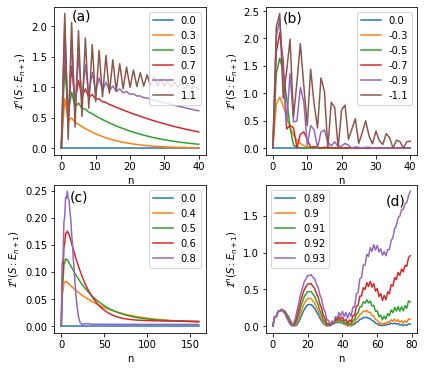

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (6.5,6))
plt.subplots_adjust(wspace=0.4)

# (a) (BS)
for λe in [0.0, 0.3, 0.5, 0.7, 0.9, 1.1]:
    x = list(γBS[λe].keys())
    y = [MutualInformation(γBS[λe][n]) for n in x]
    ax1.plot(x, y, label = λe)
ax1.legend()    
ax1.set_xlabel('n')
ax1.set_ylabel(r'$\mathcal{I}^n(S:E_{n+1})$')
ax1.text(3,2.1,'(a)',fontsize=14)

# (b) (BS)
for λe in [0.0, -0.3, -0.5, -0.7,-0.9, -1.1]:
    x = list(γBS[λe].keys())
    y = [MutualInformation(γBS[λe][n]) for n in x]
    ax2.plot(x, y, label = λe)
ax2.legend()    
ax2.set_xlabel('n')
ax2.set_ylabel(r'$\mathcal{I}^n(S:E_{n+1})$')
ax2.text(3,2.3,'(b)',fontsize=14)

# (c) (TMS)
for νe in [0.0, 0.4, 0.5, 0.6, 0.8]:
    x = list(γTMS[νe].keys())
    y = [MutualInformation(γTMS[νe][n]) for n in x]
    ax3.plot(x, y, label = νe)
ax3.legend()    
ax3.set_xlabel('n')
ax3.set_ylabel(r'$\mathcal{I}^n(S:E_{n+1})$')
ax3.text(10,0.23,'(c)',fontsize=14)

# (d) (TMS)
for νe in [0.89, 0.9, 0.91, 0.92, 0.93]:
    x = list(γTMS[νe].keys())[0:80]
    y = [MutualInformation(γTMS[νe][n]) for n in x]
    ax4.plot(x, y, label = νe)
ax4.legend()    
ax4.set_xlabel('n')
ax4.set_ylabel(r'$\mathcal{I}^n(S:E_{n+1})$')
ax4.text(65,1.65,'(d)',fontsize=14)

#plt.savefig('MI.pdf',bbox_inches='tight')
plt.show()

### Comparison between $\langle a^\dagger a \rangle$ and $\mathcal{I}$

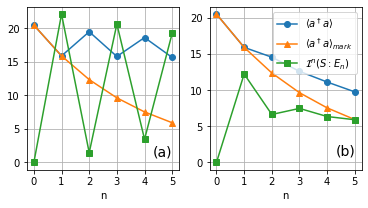

In [8]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(6,3))
λe = 1.1

x = list(γBS[λe].keys())[0:6]
y = [ada(γBS[λe][n]) for n in x]
ax1.plot(x,y, marker='o', label = '$\lambda_e = 0$')
y = [ada(γBS[0.0][n]) for n in x]
ax1.plot(x,y, marker='^', label = '$\lambda_e = 1.1$')

y = [10*MutualInformation(γBS[λe][n]) for n in x]
ax1.plot(x,y, marker='s', label = '$\mathcal{I}^n (S:E_n)$')
#ax1.legend()
ax1.grid(True)
ax1.set_xlabel('n')
ax1.set_xticks([0,1,2,3,4,5])
ax1.text(4.3,1.,'(a)',fontsize=14)

λe = 0.3
x = list(γBS[λe].keys())[0:6]
y = [ada(γBS[λe][n]) for n in x]
ax2.plot(x,y, marker='o', label = r'$\langle a^\dagger a \rangle$')
y = [ada(γBS[0.0][n]) for n in x]
ax2.plot(x,y, marker='^', label = r'$\langle a^\dagger a \rangle_{mark}$')

y = [15*MutualInformation(γBS[λe][n]) for n in x]
ax2.plot(x,y, marker='s', label = '$\mathcal{I}^n (S:E_n)$')
ax2.legend()
ax2.set_xlabel('n')
ax2.grid(True)
ax2.text(4.3,1.,'(b)',fontsize=14)
ax2.set_xticks([0,1,2,3,4,5])

#plt.savefig('ada_MI_comparison.pdf',bbox_inches='tight')
plt.show()

# 2. Memory Kernel $\mathcal{K}_n$

## Function definitions

In [11]:
# Memory Kernel
# Accepts n as a single number or as a list
def memory_kernel(X, n_vals):
    number_of_ancillas = (len(X)-2)/2
    pi = np.zeros((4,len(X)**2))
    pi[0,0] = pi[1,1] = pi[2,4] = pi[3,5] = 1
    P  = pi.T@pi
    Q  = np.eye(len(X)**2) - P
    X2 = kron(X,X)
    d = Q@X2@Q
    
    if (type(n_vals) == int):         # n_vals is a single number   
        return pi@X2@Q@mpow(d,n_vals)@Q@X2@pi.T
    else:                             #n_vals is a list            
        return [pi@X2@Q@mpow(d,n)@Q@X2@pi.T for n in n_vals]

# Returns the basis elements σ0, σz, σ+ and σ-, for the space of 2x2 matrices 
def basis(a):
    if a == 1: 
        return np.eye(2)
    elif a == 'z':
        return np.array([[1,0],[0,-1.]])
    elif a == '+':
        return np.array([[0,1.0],[0,0]])
    elif a == '-':
        return np.array([[0,0],[1.,0]])

# The coefficients \kappa_{ij} 
def MK_proj(K, i, j):
    dim = int(np.sqrt(len(K)))
    A = basis(i)
    B = basis(j)
    na = tr(A.T@A)
    nb = tr(B.T@B)
    return tr(np.kron(B.T, A.T)@K)/(na*nb)


# Memory kernels for Q and P, in the case of the TMS dynamics. 
kappa_q = lambda K : MK_proj(K,1,1) + MK_proj(K,1,'z') + MK_proj(K,'z',1) + MK_proj(K,'z','z')
kappa_p = lambda K : MK_proj(K,1,1) - MK_proj(K,1,'z') - MK_proj(K,'z',1) + MK_proj(K,'z','z')

## Quick sims

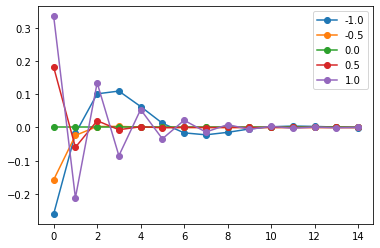

In [13]:
# Memory kernel as a function of n for the BS dynamics. 
# In the BS case, since K is proportional to the identity, it suffices to take the [0,0] element.
nf = 15
λs = 0.5 
for λe in [-1.0,-0.5,0.0,0.5,1.0]:    
    X, Y = XY_BS(λs, λe, ϵ)
    mems = memory_kernel(X, range(0,nf))
    x = range(0,nf)
    y = [mem[0,0] for mem in mems]
    plt.plot(x,y, label = λe, marker = 'o')
plt.legend()
plt.show()

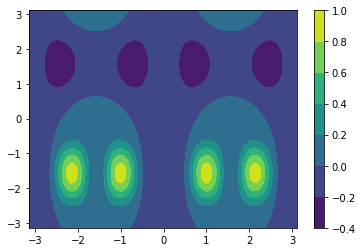

In [14]:
# Diagram in the (λs, λe) plane.
n = 1
δλ = 0.05
λrange = np.arange(-np.pi, np.pi, δλ)
tab = []
for λe in λrange:    
    for λs in λrange:
        X, Y = XY_BS(λs, λe, ϵ)
        tab.append([λs, λe, memory_kernel(X,n)[0,0]])
tab = np.array(tab)

fig, ax = plt.subplots(1,1)
cp = ax.contourf(λrange, λrange, tab[:,2].reshape((len(λrange),len(λrange))))
fig.colorbar(cp)
plt.show()           
        

### BS dynamics: $\kappa_{11}^n$ vs. $n$

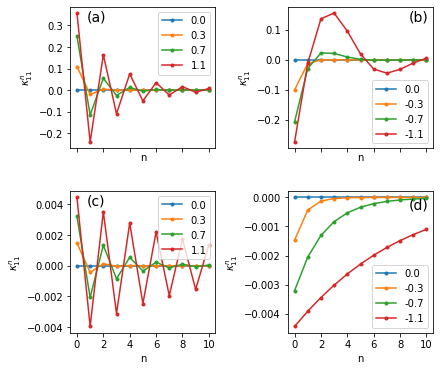

In [17]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex = True, figsize = (6.5,6))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
nf = 11
λs = 0.5 
for λe in [0.0,0.3,0.7,1.1]:    
    X, Y = XY_BS(λs, λe, ϵ)
    mems = memory_kernel(X, range(0,nf))
    x = range(0,nf)
    y = [mem[0,0] for mem in mems]
    ax1.plot(x,y, label = λe, marker = '.')

for λe in [0.0, -0.3, -0.7, -1.1]:    
    X, Y = XY_BS(λs, λe, ϵ)
    mems = memory_kernel(X, range(0,nf))
    x = range(0,nf)
    y = [mem[0,0] for mem in mems]
    ax2.plot(x,y, label = λe, marker = '.')

λs = 0.05     
for λe in [0.0,0.3,0.7,1.1]:    
    X, Y = XY_BS(λs, λe, ϵ)
    mems = memory_kernel(X, range(0,nf))
    x = range(0,nf)
    y = [mem[0,0] for mem in mems]
    ax3.plot(x,y, label = λe, marker = '.')

for λe in [0.0, -0.3, -0.7, -1.1]:    
    X, Y = XY_BS(λs, λe, ϵ)
    mems = memory_kernel(X, range(0,nf))
    x = range(0,nf)
    y = [mem[0,0] for mem in mems]
    ax4.plot(x,y, label = λe, marker = '.')


ax1.set_xlabel('n')
ax2.set_xlabel('n')
ax3.set_xlabel('n')
ax4.set_xlabel('n')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.set_ylabel(r'$\kappa_{11}^n$')
ax2.set_ylabel(r'$\kappa_{11}^n$')
ax3.set_ylabel(r'$\kappa_{11}^n$')
ax4.set_ylabel(r'$\kappa_{11}^n$')
ax1.set_xticks([0,2,4,6,8,10])
ax1.annotate('(a)', xy=(0.11,0.9), xycoords= 'axes fraction',fontsize=14)
ax2.annotate('(b)', xy=(0.83,0.9), xycoords= 'axes fraction',fontsize=14)
ax3.annotate('(c)', xy=(0.11,0.9), xycoords= 'axes fraction',fontsize=14)
ax4.annotate('(d)', xy=(0.83,0.87), xycoords= 'axes fraction',fontsize=14)
#plt.savefig('MK_BS.pdf',bbox_inches='tight')
plt.show()    

### TMS dynamics: $\kappa_{ij}^n$ vs. $n$

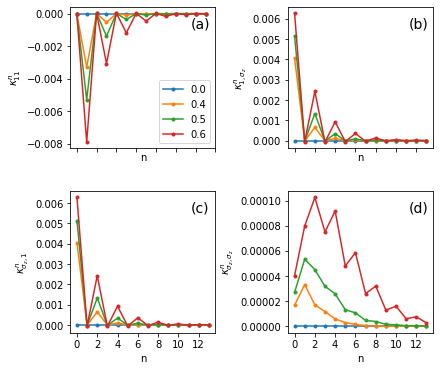

In [84]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex = True, figsize = (6.5,6))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
nf = 14
λs = 0.1
for νe in [0.0,0.4,0.5,0.6]: 
    X, Y = XY_TMS(λs, νe, ϵ)
    mems = memory_kernel(X, range(0,nf))
    x = range(0,nf)
    y = [MK_proj(mem,1,1) for mem in mems]
    ax1.plot(x,y, label = νe, marker = '.')
    y = [MK_proj(mem,1,'z') for mem in mems]
    ax2.plot(x,y, label = νe, marker = '.')
    y = [MK_proj(mem,'z',1) for mem in mems]
    ax3.plot(x,y, label = νe, marker = '.')
    y = [MK_proj(mem,'z','z') for mem in mems]
    ax4.plot(x,y, label = νe, marker = '.')

ax1.set_xlabel('n')
ax2.set_xlabel('n')
ax3.set_xlabel('n')
ax4.set_xlabel('n')
ax1.set_ylabel(r'$\kappa_{11}^n$')
ax2.set_ylabel(r'$\kappa_{1,\sigma_z}^n$')
ax3.set_ylabel(r'$\kappa_{\sigma_z,1}^n$')
ax4.set_ylabel(r'$\kappa_{\sigma_z,\sigma_z}^n$')
ax1.set_xticks([0,2,4,6,8,10,12,14])
ax1.annotate('(a)', xy=(0.83,0.85), xycoords= 'axes fraction',fontsize=14)
ax2.annotate('(b)', xy=(0.83,0.85), xycoords= 'axes fraction',fontsize=14)
ax3.annotate('(c)', xy=(0.83,0.85), xycoords= 'axes fraction',fontsize=14)
ax4.annotate('(d)', xy=(0.83,0.85), xycoords= 'axes fraction',fontsize=14)
ax1.legend()

#plt.savefig('MK_TMS_1.pdf',bbox_inches='tight')
plt.show()    

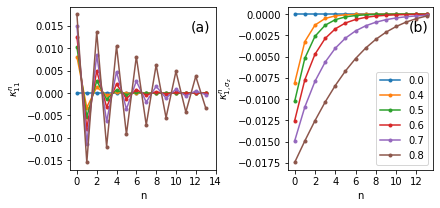

In [19]:
# Memory Kernel for Q and P in the TMS dynamics; 
fig, ((ax1,ax2)) = plt.subplots(1,2, sharex = True, figsize = (6.5,3))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
nf = 14
λs = 0.1
for νe in [0.0,0.4,0.5,0.6,0.7,0.8]: 
    X, Y = XY_TMS(λs, νe, ϵ)
    mems = memory_kernel(X, range(0,nf))
    x = range(0,nf)
    y = [kappa_q(mem) for mem in mems]
    ax1.plot(x,y, label = νe, marker = '.')
    y = [kappa_p(mem) for mem in mems]
    ax2.plot(x,y, label = νe, marker = '.')


ax1.set_xlabel('n')
ax2.set_xlabel('n')
ax1.set_ylabel(r'$\kappa_{11}^n$')
ax2.set_ylabel(r'$\kappa_{1,\sigma_z}^n$')
ax1.set_xticks([0,2,4,6,8,10,12,14])
ax1.annotate('(a)', xy=(0.83,0.85), xycoords= 'axes fraction',fontsize=14)
ax2.annotate('(b)', xy=(0.83,0.85), xycoords= 'axes fraction',fontsize=14)
ax2.legend()

#plt.savefig('MK_TMS_QP.pdf',bbox_inches='tight')
plt.show()    

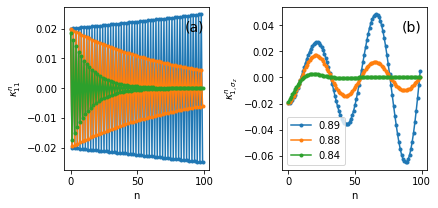

In [21]:
# Memory Kernel for Q and P in the TMS dynamics; for larger ν
fig, ((ax1,ax2)) = plt.subplots(1,2, sharex = True, figsize = (6.5,3))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
nf = 100
λs = 0.1
for νe in [0.89,0.88,0.84]: 
    X, Y = XY_TMS(λs, νe, ϵ)
    mems = memory_kernel(X, range(0,nf))
    x = range(0,nf)
    y = [kappa_q(mem) for mem in mems]
    ax1.plot(x,y, label = νe, marker = '.')
    y = [kappa_p(mem) for mem in mems]
    ax2.plot(x,y, label = νe, marker = '.')


ax1.set_xlabel('n')
ax2.set_xlabel('n')
ax1.set_ylabel(r'$\kappa_{11}^n$')
ax2.set_ylabel(r'$\kappa_{1,\sigma_z}^n$')
#ax1.set_xticks([0,2,4,6,8,10,12,14])
ax1.annotate('(a)', xy=(0.83,0.85), xycoords= 'axes fraction',fontsize=14)
ax2.annotate('(b)', xy=(0.83,0.85), xycoords= 'axes fraction',fontsize=14)
ax2.legend()

#plt.savefig('MK_TMS_QP_divergent.pdf',bbox_inches='tight')
plt.show()    

### Memory kernel diagrams in the $(\lambda_s, \lambda_e)$ plane, for the BS dynamics

In [22]:
# Simulations (takes only a few seconds)
# The matplotlib "contourf" stores entries in a weird way, with X being the columns and Y the rows
# That is why there is a tab[j,i] down there. 

nrange = [0,1,2,3,4,5,6,7,8,9]
δλ = 0.05
λrange = np.arange(-np.pi, np.pi, δλ)
mkBS = dict()
for n in nrange: 
    tab = np.zeros((len(λrange), len(λrange)))
    for i,λs in enumerate(λrange):    
        for j,λe in enumerate(λrange):
            X, Y = XY_BS(λs, λe, ϵ)
            tab[j,i]=memory_kernel(X,n)[0,0]
    mkBS[n] = np.array(tab)

maxval = max([max(mkBS[n].flatten()) for n in nrange])+0.05
minval = min([min(mkBS[n].flatten()) for n in nrange])-0.05
print(minval, maxval)

-0.5209615972153895 1.0498465210166996


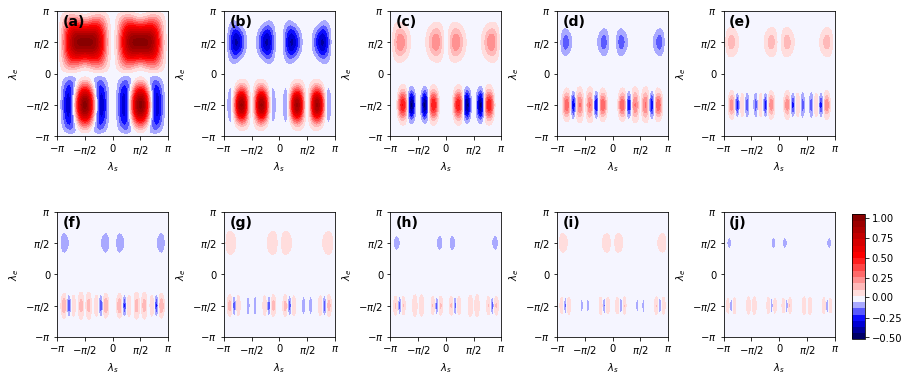

In [23]:
fig, axs = plt.subplots(2,5,figsize = (16,6))
levels = np.linspace(minval,maxval,21)
divnorm = mcolors.DivergingNorm(vmin = minval, vcenter = 0, vmax = maxval)

for i, ax in enumerate(axs.flat): 
    
    cp = ax.contourf(λrange, λrange, 
                         mkBS[nrange[i]],
                         levels = levels, cmap = 'seismic', norm = divnorm)
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlabel(r'$\lambda_s$')
    ax.set_ylabel(r'$\lambda_e$')            
    ax.set_xticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
    ax.set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])
    ax.set_yticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
    ax.set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])
    ax.annotate(letter(i), xy=(0.05,0.88), xycoords= 'axes fraction', fontsize=14, c = 'k', fontweight = 'bold')        
    
fig.subplots_adjust(right=0.8, wspace = 0.5, hspace=0.6)
cbar_ax = fig.add_axes([0.815, 0.12, 0.011, 0.29])
fig.colorbar(cp, cax = cbar_ax, ticks = [-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])

#plt.savefig('MK_BS_diagram.png',bbox_inches='tight', quality=100, dpi = 300)  
plt.show()


### Memory kernel diagrams in the $(\lambda_s, \nu_e)$ plane, for the TMS dynamics

In [24]:
# Simulations (quick; take only a few seconds)
nrange = [0,1,2,3,4]
δλ = 0.05
λrange = np.arange(-np.pi, np.pi, δλ)
νrange = np.arange(0,0.88,δλ/4)
mkTMSq = dict()
mkTMSp = dict()
for n in nrange: 
    tabq = np.zeros((len(νrange), len(λrange)))
    tabp = np.zeros((len(νrange), len(λrange)))    
    for i,λs in enumerate(λrange):    
        for j,νe in enumerate(νrange):
            X, Y = XY_TMS(λs, νe, ϵ)
            mem = memory_kernel(X,n)
            tabq[j,i] = kappa_q(mem)
            tabp[j,i] = kappa_p(mem)            
    mkTMSq[n] = np.array(tabq)
    mkTMSp[n] = np.array(tabp)    

maxvalq = max([max(mkTMSq[n].flatten()) for n in nrange])+0.05
minvalq = min([min(mkTMSq[n].flatten()) for n in nrange])-0.05
print(minvalq, maxvalq)

maxvalp = max([max(mkTMSq[n].flatten()) for n in nrange])+0.05
minvalp = min([min(mkTMSq[n].flatten()) for n in nrange])-0.05
print(minvalq, maxvalq)

-0.4261738150261066 1.0321720133787564
-0.4261738150261066 1.0321720133787564


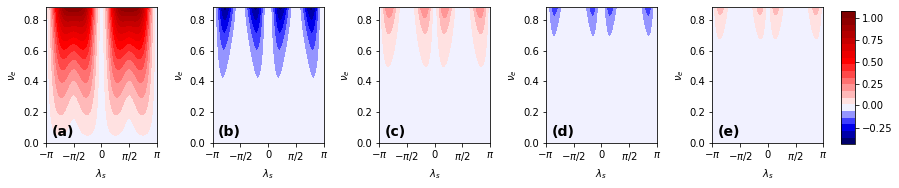

In [25]:
# Plots for kappa_q
minval = minvalq
maxval = maxvalq

fig, axs = plt.subplots(1,5,figsize = (16,2.5))
levels = np.linspace(minval,maxval+0.05,21)
divnorm = mcolors.DivergingNorm(vmin = minval, vcenter = 0, vmax = maxval)
i = 0
for n in nrange: 
    cp = axs[i].contourf(λrange, νrange, 
                         mkTMSq[n],
                         levels = levels, cmap = 'seismic', norm = divnorm)
    axs[i].set_xlim(-np.pi,np.pi)
    axs[i].set_ylim(0,0.882)
    axs[i].set_ylabel(r'$\nu_e$')        
    axs[i].set_xlabel(r'$\lambda_s$')
    axs[i].set_xticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
    axs[i].set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])
    
    axs[i].annotate(letter(i), xy=(0.05,0.05), xycoords= 'axes fraction', fontsize=14, c = 'k', fontweight = 'bold')            
    i += 1
    
fig.subplots_adjust(right=0.8, wspace = 0.5, hspace=0.6)
cbar_ax = fig.add_axes([0.815, 0.12, 0.012, 0.74])
fig.colorbar(cp, cax = cbar_ax, ticks = [-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])  
#plt.savefig('MK_TMS_diagram_Q.png',bbox_inches='tight', quality=100, dpi = 300)  
plt.show()


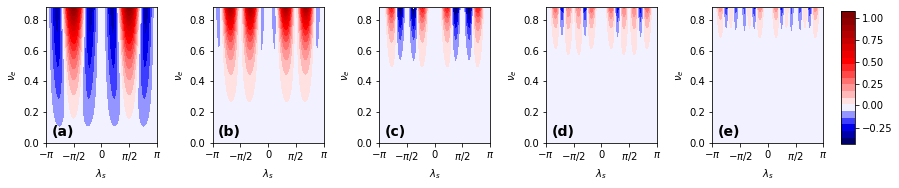

In [26]:
# Plots for kappa_p
minval = minvalp
maxval = maxvalp

fig, axs = plt.subplots(1,5,figsize = (16,2.5))
levels = np.linspace(minval,maxval+0.05,21)
divnorm = mcolors.DivergingNorm(vmin = minval, vcenter = 0, vmax = maxval)
i = 0
for n in nrange: 
    cp = axs[i].contourf(λrange, νrange, 
                         mkTMSp[n],
                         levels = levels, cmap = 'seismic', norm = divnorm)
    axs[i].set_xlim(-np.pi,np.pi)
    axs[i].set_ylim(0,0.882)
    axs[i].set_ylabel(r'$\nu_e$')        
    axs[i].set_xlabel(r'$\lambda_s$')
    axs[i].set_xticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
    axs[i].set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])
    
    axs[i].annotate(letter(i), xy=(0.05,0.05), xycoords= 'axes fraction', fontsize=14, c = 'k', fontweight = 'bold')            
    i += 1
    
fig.subplots_adjust(right=0.8, wspace = 0.5, hspace=0.6)
cbar_ax = fig.add_axes([0.815, 0.12, 0.012, 0.74])
fig.colorbar(cp, cax = cbar_ax, ticks = [-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])  
#plt.savefig('MK_TMS_diagram_P.png',bbox_inches='tight', quality=100, dpi = 300)  
plt.show()


# 3. CP Divisibility

## Function definitions

The functions in this section only make sense for $m > n$.

In [29]:
# The matrices X_n and Y_n
def CP_XnYn(X, Y, ϵ, n):
    powX = mpow(X,n)
    Xn = powX[0:2,0:2]
    Xn12 = powX[0:2,2:4]
    Yn = Xn12@ϵ@(Xn12.T)
    powX = np.eye(4)
    for s in range(0,n):
        Yn = Yn + (powX@Y@powX.T)[0:2,0:2]       # Same as text, but with s = n-r-1
        powX = powX@X
    return Xn, Yn

# The matrices X_{mn} and Y_{mn}, m > n
def CP_XmnYmn(X, Y, ϵ, n, m):
    Xn, Yn = CP_XnYn(X, Y, ϵ, n)
    Xm, Ym = CP_XnYn(X, Y, ϵ, m)
    Xmn = Xm@(np.linalg.inv(Xn))
    Ymn = Ym - Xmn@Yn@Xmn.T
    
    return Xmn, Ymn

# The CP monotone N_{mn}
def CP_quantifier(Xmn, Ymn):
    Ω = Symplectic_Omega(Xmn)
    M = 2*Ymn + 1j*Ω - 1j*(Xmn@Ω@Xmn.T)  
    eigs = eigvals(M)
    quant = 0.0 
    for eig in eigs:
        quant += 0.5*(np.abs(eig)-eig) 
    return np.real(quant)


# Wrapper function, that combines the previous definitions into a single call.
def CP_test(X, Y, ϵ, n, m):
    
    Xmn, Ymn = CP_XmnYmn(X, Y, ϵ, n, m)
    return CP_quantifier(Xmn, Ymn)

### Quick sims

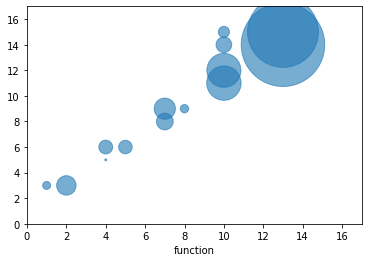

In [30]:
# CP in the (n,m) plane
λs = 1.1
λe = -0.7
nf = 17
X,Y = XY_BS(λs, λe, ϵ)

nvals = []
mvals = []
svals = []

for n in range(0,nf):
    for m in range(n+1,nf):
        test = CP_test(X, Y, ϵ, n, m)
        if (abs(test) > 10**(-12)):
            nvals.append(n)
            mvals.append(m)
            svals.append(100*test)
        
plt.scatter(nvals, mvals, s = svals, alpha = 0.6)        
plt.xlim(0,nf)
plt.xlabel('function')
plt.ylim(0,nf)

plt.show()                   

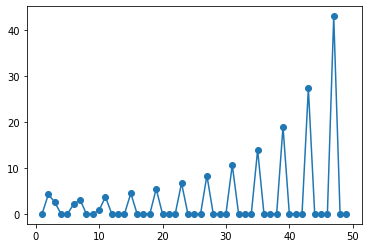

In [46]:
# N_{mn} vs. n with m = n+1
λs = 0.8
λe = -0.7
nf = 50
X,Y = XY_BS(λs, λe, ϵ)

Nvals = [CP_test(X,Y,ϵ,n,n+1) for n in range(1,nf)]
plt.plot(range(1,nf),Nvals, marker='o')
plt.show()

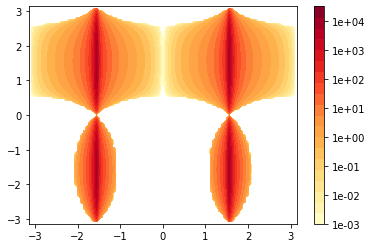

In [32]:
# (λs,λe) diagram for m = n+1
λrange = np.linspace(-np.pi, np.pi,100)
n = 1
tab = []
for λs in λrange: 
    for λe in λrange: 
        X,Y = XY_BS(λs, λe, ϵ)
        tab.append(CP_test(X, Y, ϵ, n, n+1))
        
tab = np.array(tab)
tab = np.log10(tab)
locator = ticker.LogLocator(base=10)
fig, ax = plt.subplots(1,1)
levels = np.linspace(-3,4.5,21)
cp = ax.contourf(λrange, λrange, (tab.reshape((len(λrange),len(λrange))).T),
                levels = levels, 
                 cmap = 'YlOrRd')

cbar = fig.colorbar(cp, ticks = [-3,-2,-1,0,1,2,3,4])
cbar.set_ticklabels(['1e-03','1e-02','1e-01','1e+00','1e+01','1e+02','1e+03','1e+04'])
plt.show()           

### BS dynamics: divisibility in the $(n,m)$ plane

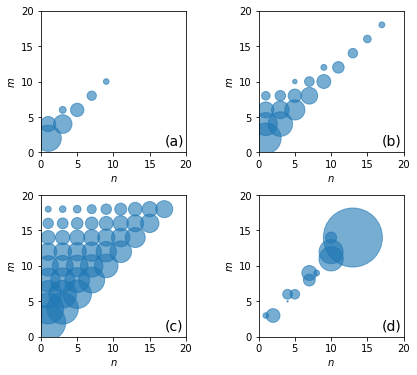

In [83]:
def CP_nm_grid(X, Y, ϵ, nf, scale = 300):
    nvals = []
    mvals = []
    svals = []
    for n in range(0,nf):
        for m in range(n+1,nf):
            test = CP_test(X, Y, ϵ, n, m)
            if (abs(test) > 10**(-12)):
                nvals.append(n)
                mvals.append(m)
                svals.append(scale*test)
    return nvals, mvals, svals


fig, axs = plt.subplots(2,2, figsize = (6.5,6))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
nf = 20

λerange = [0.75, 0.9, 1.1, -0.7];

for i, ax in enumerate(axs.flat):
    nvals, mvals, svals = CP_nm_grid(*XY_BS(1.1, λerange[i], ϵ), ϵ, (15 if i == 3 else nf), (50 if i == 3 else 200))    
    ax.scatter(nvals, mvals, s = svals, alpha = 0.6)
    ax.set_xlabel(r'$n$')
    ax.set_ylabel(r'$m$')
    ax.set_xlim(0,nf)
    ax.set_ylim(0,nf)
    ax.annotate(letter(i), xy=(0.85,0.05), xycoords= 'axes fraction', fontsize=14, c = 'k')         


#plt.savefig('CP_example.pdf',bbox_inches='tight')
plt.show()

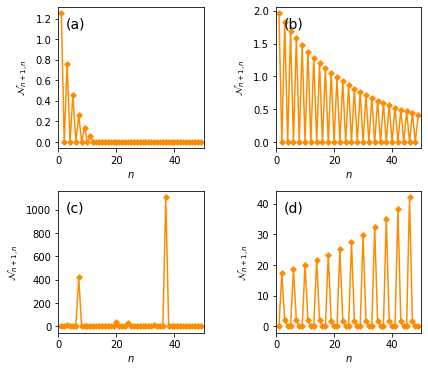

In [88]:
fig, axs = plt.subplots(2,2, figsize = (6.5,6))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
nf = 50


Nvals = [[CP_test(*XY_BS(0.8,0.9, ϵ),ϵ,n,n+1) for n in range(1,nf)],
         [CP_test(*XY_BS(0.8,1.3, ϵ),ϵ,n,n+1) for n in range(1,nf)],
         [CP_test(*XY_BS(0.8,-0.5, ϵ),ϵ,n,n+1) for n in range(1,nf)],
         [CP_test(*XY_BS(0.8,-0.8, ϵ),ϵ,n,n+1) for n in range(1,nf)]]

for i, ax in enumerate(axs.flat):
    ax.plot(range(1,nf), Nvals[i], marker = 'D',markersize=4, c = 'darkorange')
    ax.set_xlabel(r'$n$')
    ax.set_ylabel(r'$\mathcal{N}_{n+1,n}$')
    ax.set_xlim(0,nf)
    ax.annotate(letter(i), xy=(0.05,0.85), xycoords= 'axes fraction', fontsize=14, c = 'k')            

#plt.savefig('CP_example_func_n.pdf',bbox_inches='tight')
plt.show()

### BS dynamics: single-collision CP diagrams $(n,m) = (n,n+1)$

In [35]:
# Run as is if sims are to be loaded from file. 
# To rerun the sims from stracth, uncomment 1st line and comment 2nd.

#sims = dict() 
sims = load_obj('CP_sims_BS_nnp1')
nrange=[1,2,3,4,5,6,7,8,9,10,20,21,30,31,40,41,50,51,100,101]
λrange = np.linspace(-np.pi, np.pi, 250)

In [582]:
# Runs a set of simulations. Takes approx. 1h
# No need to run if one already has the .pkl file.

# for δ in [1,2,3]:
#     for n in nrange:
#         tab = []
#         for λs in λrange:
#             for λe in λrange:
#                 X,Y = XY_BS(λs, λe, ϵ)
#                 tab.append(CP_test(X, Y, ϵ, n, n+δ))

#         sims[n,n+δ] = np.log10(np.array(tab))
# save_obj(sims, 'CP_sims_BS_nnp1')       

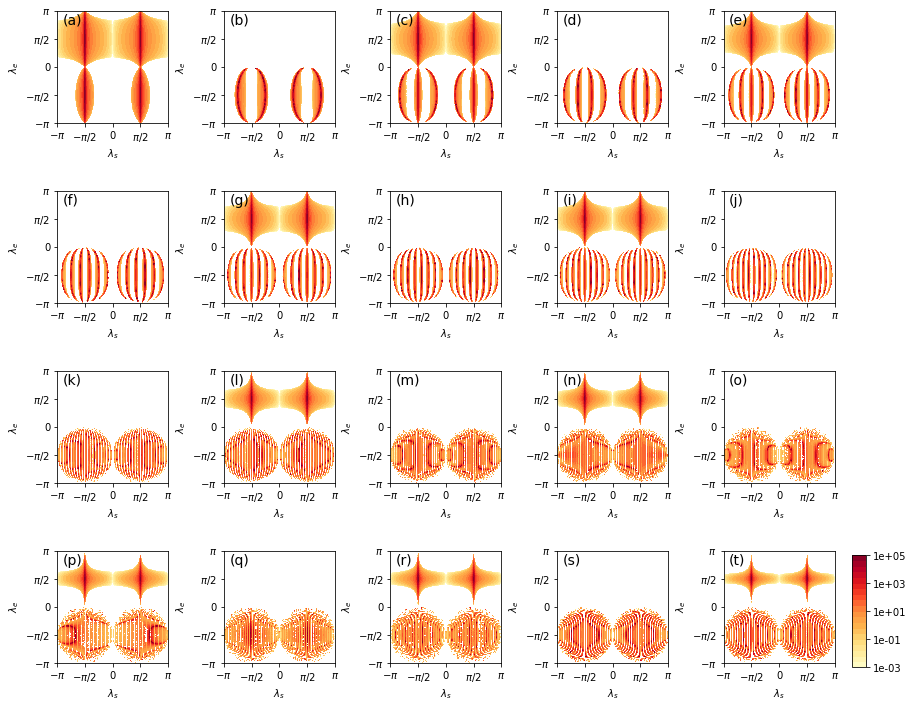

In [36]:
fig, axs = plt.subplots(4,5,figsize = (16,12))
levels = np.linspace(-3,5,21)

for i,ax in enumerate(axs.flat): 
    
    n = nrange[i]
    cp = ax.contourf(λrange, λrange, (sims[n,n+1].reshape((len(λrange),len(λrange))).T),
                 levels = levels, 
                 cmap = 'YlOrRd')

    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlabel(r'$\lambda_s$')
    ax.set_ylabel(r'$\lambda_e$')            
    ax.set_xticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
    ax.set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])
    ax.set_yticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
    ax.set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])
    ax.annotate(letter(i), xy=(0.05,0.88), xycoords= 'axes fraction', fontsize=14, c = 'k')        

    
fig.subplots_adjust(right=0.8, wspace = 0.5, hspace=0.6)
cbar_ax = fig.add_axes([0.815, 0.12, 0.012, 0.13])
cbar = fig.colorbar(cp, cax = cbar_ax, ticks = [-3,-1,1,3,5])
cbar.set_ticklabels(['1e-03','1e-01','1e+01','1e+03','1e+05'])
    
#plt.savefig('CP_BS_diagram.png',bbox_inches='tight', quality=100, dpi = 300)   
plt.show()

### BS dynamics: single-collision CP diagrams $(n,m) = (1,m)$

In [38]:
# Same logic as above.

#sims = dict() 
sims = load_obj('CP_sims_BS_11pm')
mrangefull=[2,3,4,5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30]
mrange=[2,4,6,8,10,12,14,16,18,20]
λrange = np.linspace(-np.pi, np.pi, 250)

In [ ]:
# for m in mrange:
#     tab = []
#     for λs in λrange:
#         for λe in λrange:
#             X,Y = XY_BS(λs, λe, ϵ)
#             tab.append(CP_test(X, Y, ϵ, 1, m))

#     sims[m] = np.log10(np.array(tab))
# save_obj(sims, 'CP_sims_BS_11pm')       

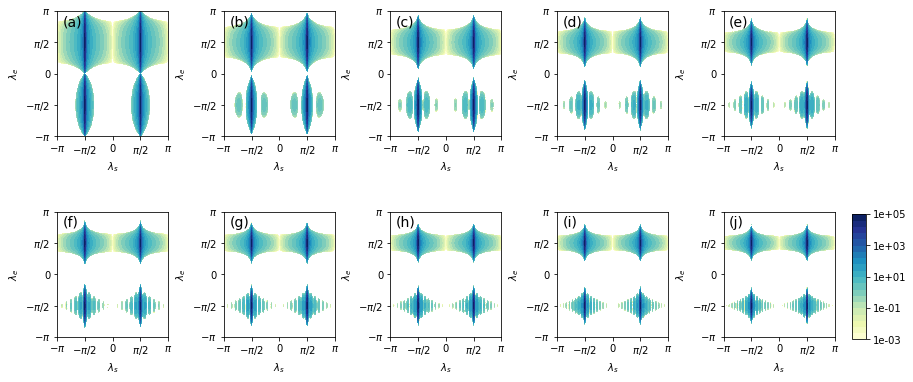

In [39]:
fig, axs = plt.subplots(2,5,figsize = (16,6))
levels = np.linspace(-3,5,21)
for i, ax in enumerate(axs.flat):
    
    m = mrange[i]

    cp = ax.contourf(λrange, λrange, (sims[m].reshape((len(λrange),len(λrange))).T),
                 levels = levels, 
                 cmap = 'YlGnBu')

    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlabel(r'$\lambda_s$')
    ax.set_ylabel(r'$\lambda_e$')            
    ax.set_xticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
    ax.set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])
    ax.set_yticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
    ax.set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])
    ax.annotate(letter(i), xy=(0.05,0.88), xycoords= 'axes fraction', fontsize=14, c = 'k')        
    
fig.subplots_adjust(right=0.8, wspace = 0.5, hspace=0.6)
cbar_ax = fig.add_axes([0.815, 0.12, 0.012, 0.29])
cbar = fig.colorbar(cp, cax = cbar_ax, ticks = [-3,-1,1,3,5])
cbar.set_ticklabels(['1e-03','1e-01','1e+01','1e+03','1e+05'])

#plt.savefig('CP_BS_diagram_11pm.png',bbox_inches='tight', quality=100, dpi = 300)   
plt.show()

### Maximization over all $(n,m)$

In [42]:
# Uses all previous simulations. 
# Requires the .pkl file.

tmp = []
sims = load_obj('CP_sims_BS_nnp1')
nrange=[1,2,3,4,5,6,7,8,9,10,20,21,30,31,40,41,50,51,100,101]

for n in nrange: 
    for δ in [1,2,3]:
        tmp.append(sims[n,n+δ])
    
sims = load_obj('CP_sims_BS_11pm')
mrangefull=[2,3,4,5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30]

for m in mrangefull: 
    tmp.append(sims[m])
    
tmp=np.array(tmp).T
simsMax = np.array([max(t) for t in tmp])

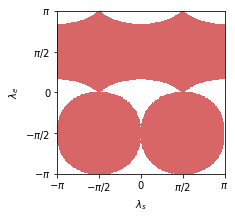

In [43]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
levels = np.linspace(-12,12,2)
cp = ax.contourf(λrange, λrange, (simsMax.reshape((len(λrange),len(λrange))).T),
                levels = levels, 
                 cmap = 'gist_heat', alpha = 0.6)

ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
ax.set_ylabel(r'$\lambda_e$')        
ax.set_xlabel(r'$\lambda_s$')
ax.set_xticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
ax.set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])
ax.set_yticks([-np.pi,-np.pi/2, 0, np.pi/2,np.pi])
ax.set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'0',r'$\pi/2$',r'$\pi$'])

#plt.savefig('CP_BS_consolidated.png',bbox_inches='tight', quality=100, dpi = 300)   
plt.show()           

## TMS dynamics: single-collision CP diagrams $(n,n+1)$

In [44]:
# Same logic as above

#sims = dict() 
sims = load_obj('CP_sims_TMS_nnp1')
nrange=[1,2,3,4,5,6,7,8,9,10]
λrange = np.linspace(0, np.pi,250)
νrange = np.linspace(0,1.4,250)

In [ ]:
# Runs all simulations. Takes around 5 minutes
# for n in [1,2,3,4,5,6,7,8,9,10]:
#     tab = []
#     for λs in λrange:
#         for νe in νrange:
#             X,Y = XY_TMS(λs, νe, ϵ)
#             tab.append(CP_test(X, Y, ϵ, n, n+1))

#     sims[n,n+δ] = np.log10(np.array(tab))
# save_obj(sims, 'CP_sims_TMS_nnp1')       

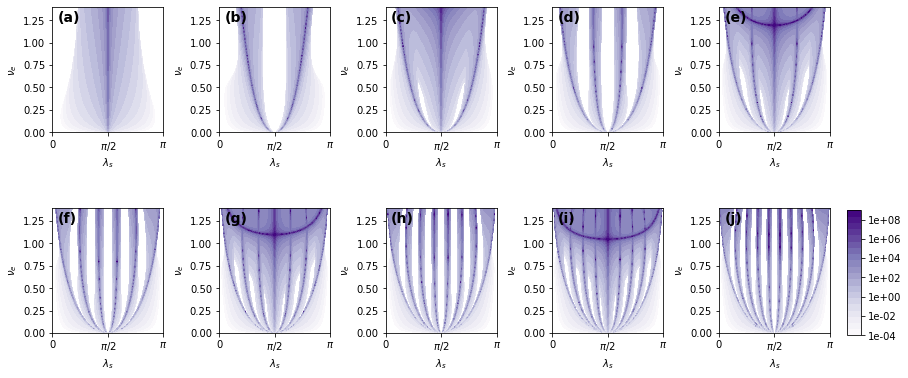

In [45]:
fig, axs = plt.subplots(2,5,figsize = (16,6))
levels = np.linspace(-4,9,21)
nrange = [1,2,3,4,5,6,7,8,9,10]
for i, ax in enumerate(axs.flat):     
    n = nrange[i]
    cp = ax.contourf(λrange, νrange, (sims[n,n+1].reshape((len(λrange),len(νrange))).T),
                 levels = levels, 
                 cmap = 'Purples')

    ax.set_xlim(0,np.pi)
    ax.set_ylim(0,1.4)
    ax.set_xlabel(r'$\lambda_s$')
    ax.set_ylabel(r'$\nu_e$')        
    ax.set_xticks([0, np.pi/2,np.pi])
    ax.set_xticklabels([r'0',r'$\pi/2$',r'$\pi$'])
    ax.annotate(letter(i), xy=(0.05,0.88), xycoords = 'axes fraction', fontsize=14, c = 'k', fontweight = 'bold')        
    
fig.subplots_adjust(right=0.8, wspace = 0.5, hspace=0.6)
cbar_ax = fig.add_axes([0.815, 0.12, 0.012, 0.29])
cbar = fig.colorbar(cp, cax = cbar_ax, ticks = [-4,-2,0,2,4,6,8])
cbar.set_ticklabels(['1e-04','1e-02','1e+00','1e+02','1e+04','1e+06','1e+08'])

#plt.savefig('CP_TMS_diagram.png',bbox_inches='tight', quality=100, dpi = 300)   
plt.show()